In [3]:
import torch
import torchvision

In [4]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [5]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST\raw\train-images-idx3-ubyte.gz to /files/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST\raw\train-labels-idx1-ubyte.gz to /files/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST\raw\t10k-images-idx3-ubyte.gz to /files/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST\raw\t10k-labels-idx1-ubyte.gz to /files/MNIST\raw



In [6]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [7]:
example_data.shape

torch.Size([1000, 1, 28, 28])

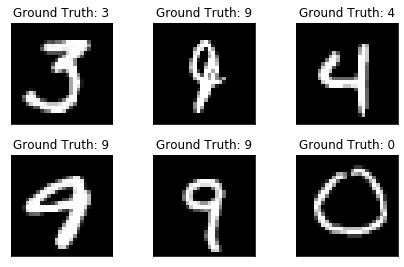

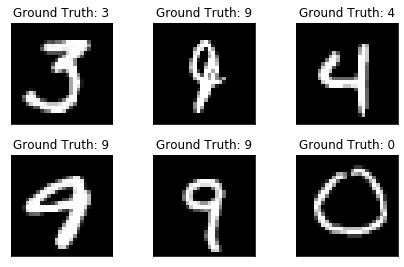

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [9]:
example_data[1][0]

tensor([[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [12]:
class Simple_Net(nn.Module):
    def __init__(self):
        super(Simple_Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

In [13]:
simple_network = Simple_Net()
optimizer = optim.SGD(simple_network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [14]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [15]:
def train(network, optimizer, epoch, train_losses, train_counter, print_info = True):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      if print_info:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './model.pth')
      torch.save(optimizer.state_dict(), './optimizer.pth')

In [16]:
def test(network, test_losses):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [17]:
%%time
test(simple_network, test_losses)
for epoch in range(1, n_epochs + 1):
  train(simple_network, optimizer, epoch, train_losses, train_counter, True)
  test(simple_network, test_losses)

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
C:\tools\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3204, Accuracy: 823/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320810
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.309956
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.204622
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.144785
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.075159
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.914722
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.872151
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.634297
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.451464
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.189690
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.041302
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.078601
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.921918
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.891757
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.767973
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.814411
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.569233
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.573007
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.537260
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.179482
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.173913
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.270773
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.131800
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.134195
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.291130
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.284875
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.169987
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.358879
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.199129
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.136240
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.172108
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.108764
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.509187
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.116726
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.258072
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.206528
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.163507
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.110977
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.166564


Text(0, 0.5, 'negative log likelihood loss')

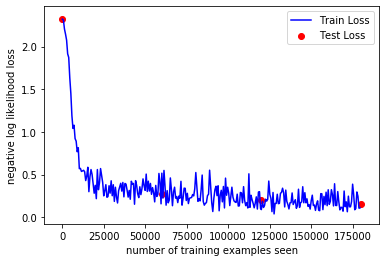

In [18]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [19]:
with torch.no_grad():
  output = simple_network(example_data)

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


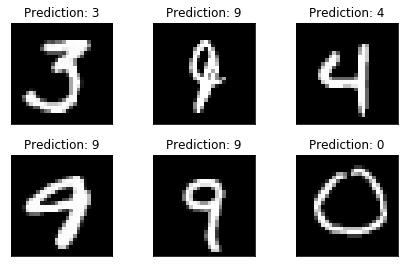

In [20]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

In [21]:
bad = [i for  i in range(1000) if output.data.max(1, keepdim=True)[1][i].item() != example_targets[i]]

In [22]:
len(bad)

53

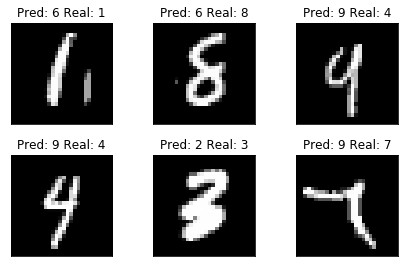

In [23]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[bad[i]][0], cmap='gray', interpolation='none')
  plt.title("Pred: {} Real: {}".format(
    output.data.max(1, keepdim=True)[1][bad[i]].item(), example_targets[bad[i]]))
  plt.xticks([])
  plt.yticks([])

In [24]:
continued_network = Simple_Net()
continued_optimizer = optim.SGD(continued_network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [25]:
network_state_dict = torch.load("model.pth")
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load("optimizer.pth")
continued_optimizer.load_state_dict(optimizer_state_dict)

In [26]:
%%time
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(continued_network, continued_optimizer, i, train_losses, train_counter, False)
  test(continued_network, test_losses)

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]



Test set: Avg. loss: 0.1380, Accuracy: 9585/10000 (96%)


Test set: Avg. loss: 0.1141, Accuracy: 9645/10000 (96%)


Test set: Avg. loss: 0.1052, Accuracy: 9679/10000 (97%)


Test set: Avg. loss: 0.0947, Accuracy: 9709/10000 (97%)


Test set: Avg. loss: 0.0900, Accuracy: 9713/10000 (97%)

Wall time: 3min 30s


In [27]:
%%time
for i in range(9,14):
  test_counter.append(i*len(train_loader.dataset))
  train(continued_network, continued_optimizer, i, train_losses, train_counter, False)
  test(continued_network, test_losses)

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]



Test set: Avg. loss: 0.0844, Accuracy: 9730/10000 (97%)


Test set: Avg. loss: 0.0829, Accuracy: 9736/10000 (97%)


Test set: Avg. loss: 0.0778, Accuracy: 9754/10000 (98%)


Test set: Avg. loss: 0.0742, Accuracy: 9767/10000 (98%)


Test set: Avg. loss: 0.0698, Accuracy: 9778/10000 (98%)

Wall time: 2min 4s


Text(0, 0.5, 'negative log likelihood loss')

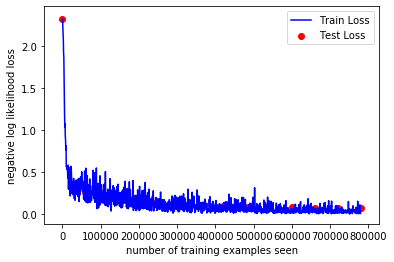

In [28]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [30]:
conv_network = Net()
optimizer = optim.SGD(conv_network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [31]:
conv_train_losses = []
conv_train_counter = []
conv_test_losses = []
conv_test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [32]:
%%time
test(conv_network, conv_test_losses)
for epoch in range(1, n_epochs + 1):
  train(conv_network, optimizer, epoch, conv_train_losses, conv_train_counter, True)
  test(conv_network, conv_test_losses)

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3167, Accuracy: 986/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.321712
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.278752
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298218
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.249570
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.239993
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.231383
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.224427
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.103338
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.108814
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.960340
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.915859
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.682681
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.493476
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.591703
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.469570
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.457554
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.171996
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.439364
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.132398
Train Epoch: 1 [12160/

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.271426
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.282481
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.303695
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.251624
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.352667
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.239515
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.273371
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.486889
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.311224
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.296303
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.333306
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.205246
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.256252
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.256199
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.224454
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.234943
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.166538
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.418010
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.233936
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.407805


Text(0, 0.5, 'negative log likelihood loss')

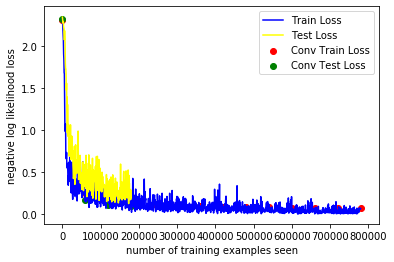

In [38]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.plot(conv_train_counter, conv_train_losses, color='yellow')
plt.scatter(conv_test_counter, conv_test_losses, color='green')
plt.legend(['Train Loss', 'Test Loss', 'Conv Train Loss', 'Conv Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')